<a href="https://colab.research.google.com/github/AlsoSprachZarathushtra/Quick-Draw-Recognition/blob/master/(3_1)Stroke_LSTM_Skatch_A_Net_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from tensorflow.keras.callbacks import CSVLogger
from ast import literal_eval

# Parameters  and  Work-Space Paths

In [0]:
# parameters
BATCH_SIZE = 200
EPOCHS = 50
STEPS_PER_EPOCH = 425
VALIDATION_STEPS = 100
EVALUATE_STEPS = 850
IMAGE_SIZE = 225
LINE_SIZE = 3


# load path
TRAIN_DATA_PATH = 'gdrive/My Drive/QW/Data/Data_10000/All_classes_10000.csv'
VALID_DATA_PATH = 'gdrive/My Drive/QW/Data/My_test_data/My_test_data.csv'
LABEL_DICT_PATH = 'gdrive/My Drive/QW/Data/labels_dict.npy'

# save path
CKPT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(3-1)Stroke_LSTM-Skatch-A-Net/best_model_3_1.ckpt'
LOSS_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(3-1)Stroke_LSTM-Skatch-A-Net/loss_plot_3_1.png'
ACC_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(3-1)Stroke_LSTM-Skatch-A-Net/acc_plot_3_1.png'
LOG_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(3-1)Stroke_LSTM-Skatch-A-Net/Log_3_1.log'
print('finish!')

finish!


# Generator

In [0]:

def generate_data(data, batch_size, choose_recognized):
    data = data.sample(frac = 1)
    
    while 1:
        
#         get columns' values named 'drawing', 'word' and 'recognized'
        drawings = data["drawing"].values
        drawing_recognized = data["recognized"].values
        drawing_class = data["word"].values
      
#         initialization
        cnt = 0
        data_X =[]
        data_Y =[]
        
#         generate batch
        for i in range(len(drawings)):
            if choose_recognized:
                if drawing_recognized[i] == 'False':    #Choose according to recognized value
                    continue
            draw = drawings[i]
            stroke_vec = literal_eval(draw)
            
            l = len(stroke_vec)
            stroke_set = []
            if l <= 3:
                if l == 1:
                    stroke_set =[[0],[0],[0]]
                if l == 2:
                    stroke_set =[[0],[1],[1]]
                if l == 3:
                    stroke_set =[[0],[1],[2]]
            if l > 3:
                a = l // 3
                b = l % 3
                c = (a + 1) * 3
                d = c - l
                n = 0
                for h in range(0,d):
                    temp = []
                    for k in range(a):
                        temp.append(n)
                        n += 1
                    stroke_set.append(temp)
                for h in range(d,3):
                    temp = []
                    for k in range(a+1):
                        temp.append(n)
                        n += 1
                    stroke_set.append(temp)
            
            img = np.zeros([256, 256])
            x = []
            stroke_num = 0
            for j in range(3):
                stroke_index = stroke_set[j]
                for m in list(stroke_index):
                    line = np.array(stroke_vec[m]).T
                    cv2.polylines(img, [line], False, (255-(13*min(stroke_num,10))), LINE_SIZE)
                    stroke_num += 1
                img_copy = img.copy()
                img_x = cv2.resize(img_copy,(IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_NEAREST)
                x.append(img_x)
            x = np.array(x)
            x = x[:,:,:,np.newaxis]
            label = drawing_class[i]
            y = labels2nums_dict[label]
            data_X.append(x)
            data_Y.append(y)
            cnt += 1
            if cnt==batch_size:        #generate a batch when cnt reaches batch_size 
                cnt = 0
                yield (np.array(data_X), np.array(data_Y))
                data_X = []
                data_Y = []
print("finish!")

finish!


# Callbacks

In [0]:
# define a class named LossHitory 
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, loss_fig_save_path, acc_fig_save_path):
        iters = range(len(self.losses[loss_type]))
        plt.figure('acc')
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right")
        plt.savefig(acc_fig_save_path)
        plt.show()
        
        
        plt.figure('loss')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.savefig(loss_fig_save_path)
        plt.show()
        
# create a object from LossHistory class
History = LossHistory()

print("finish!")

finish!


In [0]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    CKPT_PATH, 
    verbose = 1, 
    monitor='val_acc', 
    mode = 'max', 
    save_best_only=True)

print("finish!")

finish!


In [0]:
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

In [0]:
csv_logger = CSVLogger(LOG_PATH, separator=',', append=True)

# Load Data

In [0]:
# load train data and valid data
#  labels_dict and data path

# labels convert into nums
labels_dict = np.load(LABEL_DICT_PATH)
labels2nums_dict = {v: k for k, v in enumerate(labels_dict)}

# read csv 
train_data = pd.read_csv(TRAIN_DATA_PATH)
valid_data = pd.read_csv(VALID_DATA_PATH)

print('finish!')

finish!


# Model

In [0]:
def Sketch_A_Net(M):
    _x_input = Lambda(lambda x: x[:,M])(X_INPUT)

    _x = Conv2D(64, (15,15), strides=3, padding='valid',name='Conv2D_1_{}'.format(M))(_x_input)
    _x = BatchNormalization(name='BN_1_{}'.format(M))(_x)
    _x = ReLU(name='ReLU_1_{}'.format(M))(_x)
    _x = MaxPool2D(pool_size=(3,3),strides=2, name='Pooling_1_{}'.format(M))(_x)

    _x = Conv2D(128, (5,5), strides=1, padding='valid',name='Conv2D_2_{}'.format(M))(_x)
    _x = BatchNormalization(name='BN_2_{}'.format(M))(_x)
    _x = ReLU(name='ReLU_2_{}'.format(M))(_x)
    _x = MaxPool2D(pool_size=(3,3),strides=2, name='Pooling_2_{}'.format(M))(_x)

    _x = Conv2D(256, (3,3), strides=1, padding='same',name='Conv2D_3_{}'.format(M))(_x)
    _x = BatchNormalization(name='BN_3_{}'.format(M))(_x)
    _x = ReLU(name='ReLU_3_{}'.format(M))(_x)

    _x = Conv2D(256, (3,3), strides=1, padding='same',name='Conv2D_4_{}'.format(M))(_x)
    _x = BatchNormalization(name='BN_4_{}'.format(M))(_x)
    _x = ReLU(name='ReLU_4_{}'.format(M))(_x)

    _x = Conv2D(256, (3,3), strides=1, padding='same',name='Conv2D_5_{}'.format(M))(_x)
    _x = BatchNormalization(name='BN_5_{}'.format(M))(_x)
    _x = ReLU(name='ReLU_5_{}'.format(M))(_x)
    _x = MaxPool2D(pool_size=(3,3),strides=2, name='Pooling_5_{}'.format(M))(_x)

    _x_shape = _x.shape[1]
    _x = Conv2D(512, (int(_x_shape),int(_x_shape)), strides=1, padding='valid',name='Conv2D_FC_6_{}'.format(M))(_x)
    _x = BatchNormalization(name='BN_6_{}'.format(M))(_x)
    _x = Reshape((512,),name='Reshape_{}'.format(M))(_x)
    return _x

X_INPUT = Input(shape=(3,IMAGE_SIZE,IMAGE_SIZE,1))
x1_output = Sketch_A_Net(0)
x2_output = Sketch_A_Net(1)
x3_output = Sketch_A_Net(2)

x = concatenate([x1_output, x2_output,x3_output],axis = 1,name='Concatenate')
x = Reshape((3,512),name='Reshape_f1')(x)
x = LSTM(512, return_sequences=True, name='LSTM_1')(x)
x = BatchNormalization(name='BN_1')(x)
x = Dropout(0.5, name='Dropout_1')(x)
x = LSTM(512, return_sequences=False, name='LSTM_2')(x)
x = BatchNormalization(name='BN_2')(x)
x = Dropout(0.5, name='Dropout_2')(x)
xx = concatenate([x,x3_output],axis = 1,name='Concatenate_last')
xx = Reshape((1024,),name='Reshape_f2')(xx)
xx = Dense(340, name='FC')(xx)
X_OUTPUT = Softmax(name='Softmax')(xx)

MODEL = keras.Model(inputs=X_INPUT, outputs= X_OUTPUT)
MODEL.summary()  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 225, 225,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 225, 225, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 225, 225, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 225, 225, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv2D_1_0

# TPU Complie

In [0]:
model = MODEL
TPU_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )

TPU_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
                  metrics=['accuracy'])


print('finish')

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.72.17.58:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 929088615968568844)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15900753977296052317)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 8765991032916183184)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 529849079297276646)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3452447291276583421)
INFO:tensorflow:*** Available Device: _DeviceAttr

# Train

start training
Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(12,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(12, 3, 225, 225, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(12, 1), dtype=tf.float32, name='Softmax_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_3
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 68.03637170791626 secs
INFO:tensorflow:Setting weights on TPU model.
424/425 [============================>.] - ETA: 1s - loss: 4.3930 - acc: 0.1663INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(12,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(12, 3, 225, 225, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(12, 1), dtype=tf.float32, name='Softmax_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping

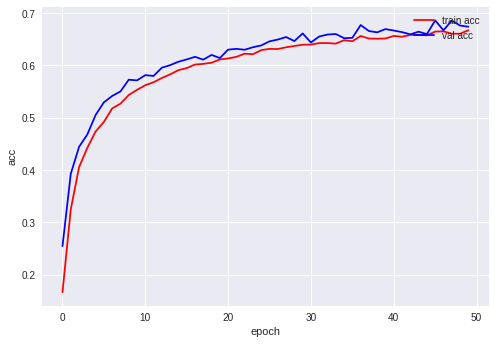

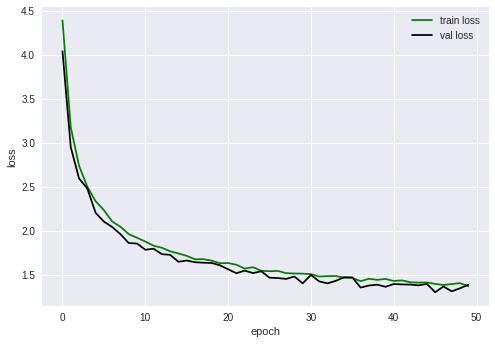

finish!


In [0]:
print('start training')
# callbacks = [History, cp_callback]

history = TPU_model.fit_generator(generate_data(train_data, BATCH_SIZE, True),
                              steps_per_epoch = STEPS_PER_EPOCH,
                              epochs = EPOCHS,
                              validation_data = generate_data(valid_data, BATCH_SIZE, False) ,
                              validation_steps = VALIDATION_STEPS,
                              verbose = 1,
                              initial_epoch = 0,
                              callbacks = [History,cp_callback,csv_logger]
                             )
print("finish training")

History.loss_plot('epoch', LOSS_PLOT_PATH, ACC_PLOT_PATH)

print('finish!')

# Evaluate

In [0]:
def top_3_accuracy(X, Y):
        return sparse_top_k_categorical_accuracy(X, Y, 3)
  
def top_5_accuracy(X, Y):
        return sparse_top_k_categorical_accuracy(X, Y, 5)
  
model_E = MODEL  


model_E.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                    optimizer=tf.train.AdamOptimizer(learning_rate=1e-4),
                    metrics=['accuracy',top_3_accuracy, top_5_accuracy])

model_weights_path = CKPT_PATH   
model_E.load_weights(model_weights_path)
print('finish')

finish


In [0]:
result = model_E.evaluate_generator(
    generate_data(valid_data, BATCH_SIZE, False),
    steps = EVALUATE_STEPS,
    verbose = 1
)
print('number of test samples:', len(result))
print('loss:', result[0])
print('top1 accuracy:', result[1])
print('top3 accuracy:', result[2])
print('top3 accuracy:', result[3])

850/850 [==============================] - 453s 532ms/step
number of test samples: 4
loss: 1.332117350802702
top1 accuracy: 0.6783235291172477
top3 accuracy: 0.8453823546802296
top3 accuracy: 0.8867411743192112
